# Youtube ASR + Diarization + SRT format

Let say you want to transcribe long audio from youtube and detect speakers using TorchAudio and save to SRT format, malaya-speech able to do that.

<div class="alert alert-info">

This tutorial is available as an IPython notebook at [malaya-speech/example/youtube-asr-diarization-torchaudio-srt](https://github.com/huseinzol05/malaya-speech/tree/master/example/youtube-asr-diarization-torchaudio-srt).
    
</div>

<div class="alert alert-warning">

This module is not language independent, so it not save to use on different languages. Pretrained models trained on hyperlocal languages.
    
</div>

<div class="alert alert-warning">

This is an application of malaya-speech Pipeline, read more about malaya-speech Pipeline at [malaya-speech/example/pipeline](https://github.com/huseinzol05/malaya-speech/tree/master/example/pipeline).
    
</div>

### Download youtube video

I use https://github.com/ytdl-org/youtube-dl to download,

```bash
pip install youtube-dl
```

In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
filename = 'LIVE - Perutusan khas oleh Perdana Menteri Muhyiddin Yassin-YzjNAOSALU8.mp3'
url = 'https://www.youtube.com/watch?v=YzjNAOSALU8&ab_channel=KiniTV'

if not os.path.exists(filename):
    import youtube_dl

    ydl_opts = {
        'format': 'bestaudio/best',
        'postprocessors': [{
            'key': 'FFmpegExtractAudio',
            'preferredcodec': 'mp3',
            'preferredquality': '192',
        }],
        'no-check-certificate': True
    }
    
    with youtube_dl.YoutubeDL(ydl_opts) as ydl:
        ydl.download([url])

In [3]:
import malaya_speech
from malaya_speech import Pipeline
from malaya_speech.utils.astype import float_to_int

`pyaudio` is not available, `malaya_speech.streaming.pyaudio` is not able to use.


### Load VAD model

We are going to use WebRTC VAD model, read more about VAD at https://malaya-speech.readthedocs.io/en/latest/load-vad.html

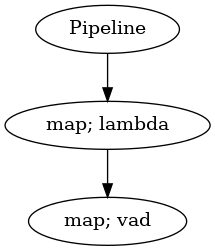

In [4]:
vad_model = malaya_speech.vad.webrtc()
p_vad = Pipeline()
pipeline = (
    p_vad.map(lambda x: float_to_int(x, divide_max_abs=False))
    .map(vad_model)
)
p_vad.visualize()

Starting malaya-speech 1.4.0, streaming always returned a float32 array between -1 and +1 values.

### Load ASR model

In [5]:
model = malaya_speech.stt.transducer.pt_transformer(model = 'mesolitica/conformer-medium')

In [6]:
_ = model.eval()

### ASR Pipeline

Feel free to add speech enhancement or any function, but in this example, I just keep it simple.

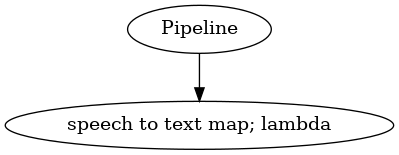

In [7]:
p_asr = Pipeline()
pipeline_asr = (
    p_asr.map(lambda x: model.beam_decoder([x])[0], name = 'speech-to-text')
)
p_asr.visualize()

**You need to make sure the last output should named as `speech-to-text` or else the streaming interface will throw an error**.

### Diarization Pipeline

In [8]:
speaker_v = malaya_speech.speaker_vector.nemo(model = 'huseinzol05/nemo-titanet_large')

In [9]:
_ = speaker_v.eval()

In [10]:
from malaya_speech.diarization import streaming_speaker_similarity
import numpy as np

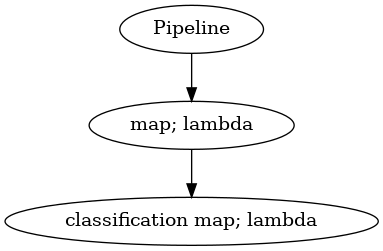

In [11]:
speakers = {}

p_classification = Pipeline()
to_float = p_classification
to_float.map(lambda x: speaker_v([x])[0]) \
.map(lambda x: streaming_speaker_similarity(x, speakers = speakers, similarity_threshold = 0.7), 
     name = 'classification')

p_classification.visualize()

Straight forward, predict each frames, if similar at least 70%, returned existing speaker, else append new speaker.

### Postfilter Pipeline

The problem with multispeaker audio, sometime there are frames got speaker overlapped each other, so I want to reject those frames.

In [12]:
speaker_overlap = malaya_speech.speaker_overlap.deep_model(model = 'vggvox-v2')

2023-04-02 16:31:34.891040: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 16:31:34.897277: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-04-02 16:31:34.897302: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: husein-MS-7D31
2023-04-02 16:31:34.897305: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: husein-MS-7D31
2023-04-02 16:31:34.897592: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.161.3
2023-04-02 16:31:34.897607: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported vers

In [13]:
is_clean = malaya_speech.is_clean.nemo(model = 'huseinzol05/nemo-is-clean-speakernet')

In [14]:
_ = is_clean.eval()

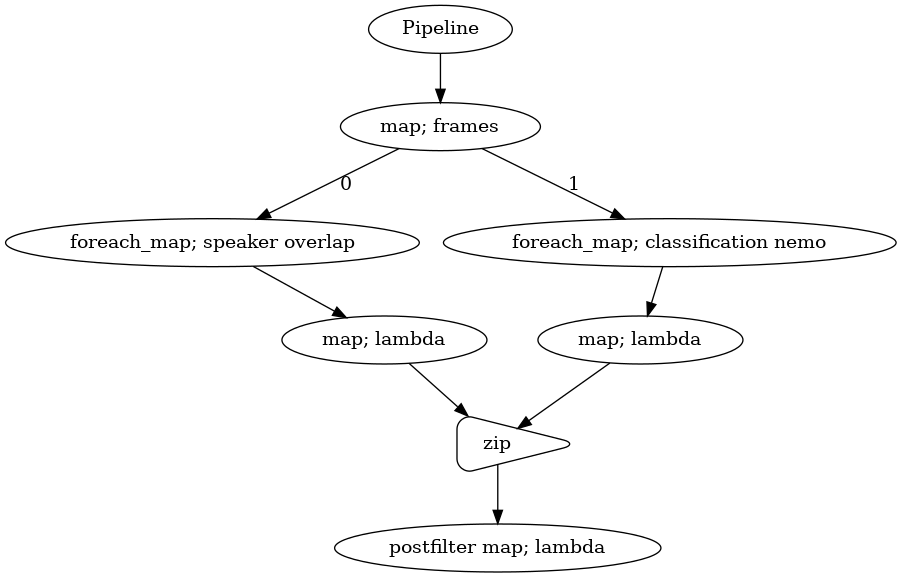

In [15]:
p_postfilter = Pipeline()
p_frames = p_postfilter.map(malaya_speech.utils.generator.frames, frame_duration_ms = 100, 
                     append_ending_trail = False)
p_speaker_overlap = p_frames.foreach_map(speaker_overlap) \
.map(lambda x: np.mean(x) <= 0.1)
is_clean_overlap = p_frames.foreach_map(is_clean) \
.map(lambda x: np.mean(x) >= 0.1)
p_speaker_overlap.zip(is_clean_overlap).map(lambda x: np.mean(x) == 1, name = 'postfilter')
p_postfilter.visualize()

The pipeline is simple, a long frame splitted into 100 ms frames, 
1. predict speaker overlapped, if those 100 ms frames are less than 10% speaker overlapped.
2. predict speeches are clean at least 10%.
3. if (1) and (2) are correct, we accept the frame.

**postfilter pipeline must returned True to accept a frame**.

**You need to make sure the last output should named as `postfilter` or else the streaming interface will throw an error**.

### Start streaming

In [24]:
samples = malaya_speech.streaming.torchaudio.stream(filename,
                                                    vad_model = p_vad, 
                                                    asr_model = p_asr,
                                                    classification_model = p_classification,
                                                    postfilter_model = p_postfilter,
                                                    segment_length = 320,
                                                    realtime_print = True,
                                                    streaming_max_length = 360)

dua ribu dua puluh satu (speaker 0) berbanding dengan suku suku sebelumnya (speaker 0) trend pemulihan yang berterusan ini adalah bukti jelas (speaker 0) bahawa dasar dasar kerajaan telah membuahkan hasil (speaker 0) walaupun dalam keadaan yang amat mencabar (speaker 0) perkembangan ini (speaker 0) disokong oleh belanjawan dua ribu dua puluh satu (speaker 0) serta pakej pakej rangsangan dan bantuan kerajaan (speaker 0) pasaran kewangan (speaker 0) dan juga modal kita menunjukkan daya tahan yang baik (speaker 0) pada suku kedua (speaker 0) dua ribu dua puluh satu (speaker 0) melangkah ke hadapan (speaker 0) dengan pelaksanaan pelan pemulihan negara (speaker 0) dan peningkatan program imunisasi kobis babas kebangsaan (speaker 0) ekonomi malaysia dijangka akan beransur pulih (speaker 0) sasaran lima puluh peratus populasi dewasa negara (speaker 0) divaksinasi sepenuhnya pada akhir ogos (speaker 0) akan membolehkan kita membuka semula kegiatan ekonomi (speaker 0) dan sosial (speaker 0) sec

In [25]:
import IPython.display as ipd

In [26]:
len(samples)

110

In [27]:
samples[0]

{'wav_data': array([0.        , 0.        , 0.        , ..., 0.00197924, 0.00197863,
        0.00188656], dtype=float32),
 'start': 0.02,
 'asr_model': 'dua ribu dua puluh satu',
 'classification_model': 'speaker 0',
 'end': 1.94}

In [28]:
ipd.Audio(samples[0]['wav_data'], rate = 16000)

### Save to SRT

You can load SRT file using VLC or something like that, `malaya_speech.utils.io.write_srt` required list of dictionary with `{start, end, text}` keys.

In [29]:
transcript = []
for s in samples:
    transcript.append({
        'start': s['start'],
        'end': s['end'],
        'text': f"{s['asr_model']} ({s['classification_model']})"
    })
    
transcript[:2]

[{'start': 0.02, 'end': 1.94, 'text': 'dua ribu dua puluh satu (speaker 0)'},
 {'start': 2.66,
  'end': 5.4,
  'text': 'berbanding dengan suku suku sebelumnya (speaker 0)'}]

In [30]:
from malaya_speech.utils.io import write_srt

with open('muhyiddin-perutusan.srt', 'w') as fopen:
    write_srt(transcript, fopen)

You can download the srt file at [malaya-speech/example/youtube-asr-diarization-torchaudio-srt/muhyiddin-perutusan.srt](https://github.com/huseinzol05/malaya-speech/blob/master/example/muhyiddin-perutusan.srt)